In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 4

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
filenames = tf.io.gfile.glob(str('/content/drive/MyDrive/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str('/content/drive/MyDrive/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1082
Pneumonia images count in training set: 3103


In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-1187-0001.jpeg'
b'/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1383_bacteria_3521.jpeg'
b'/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1310_bacteria_3297.jpeg'
b'/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person441_bacteria_1912.jpeg'
b'/content/drive/MyDrive/chest_xray/train/NORMAL/NORMAL2-IM-1051-0001.jpeg'


In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [ ]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
for item in tf.io.gfile.glob(str("/content/drive/MyDrive/chest_xray/train/*"))])
CLASS_NAMES

array(['PNEUMONIA', 'NORMAL'], dtype='<U9')

In [ ]:
def get_label(file_path):
    
    parts = tf.strings.split(file_path, os.path.sep)
   
    return parts[-2] == "PNEUMONIA"

In [ ]:
def decode_img(img):
  
  img = tf.image.decode_jpeg(img, channels=3)
  
  img = tf.image.convert_image_dtype(img, tf.float32)
  
  return tf.image.resize(img, IMAGE_SIZE)

In [ ]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [ ]:
test_list_ds = tf.data.Dataset.list_files(str('/content/drive/MyDrive/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

624

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

   
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

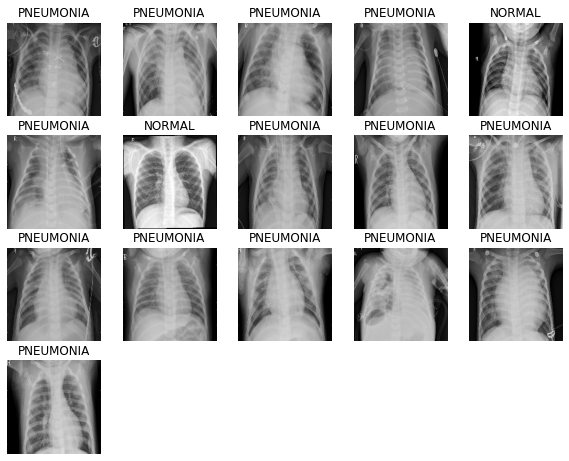

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [ ]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.05355821])

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/4
261/261 [==============================] - 485s 2s/step - loss: 0.3737 - accuracy: 0.8285 - precision: 0.9504 - recall: 0.8110 - val_loss: 0.7179 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 2/4
261/261 [==============================] - 311s 1s/step - loss: 0.2335 - accuracy: 0.9128 - precision: 0.9704 - recall: 0.9102 - val_loss: 1.4242 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 3/4
261/261 [==============================] - 311s 1s/step - loss: 0.1815 - accuracy: 0.9308 - precision: 0.9785 - recall: 0.9270 - val_loss: 0.1896 - val_accuracy: 0.9231 - val_precision: 0.9082 - val_recall: 0.9974
Epoch 4/4
261/261 [==============================] - 306s 1s/step - loss: 0.1701 - accuracy: 0.9361 - precision: 0.9820 - recall: 0.9309 - val_loss: 0.0976 - val_accuracy: 0.9663 - val_precision: 0.9830 - val_recall: 0.9716


In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=4,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/4
261/261 [==============================] - 314s 1s/step - loss: 0.4758 - accuracy: 0.7878 - precision: 0.9154 - recall: 0.7865 - val_loss: 34.6793 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000 - lr: 0.0100
Epoch 2/4
261/261 [==============================] - 310s 1s/step - loss: 0.3412 - accuracy: 0.8496 - precision: 0.9501 - recall: 0.8415 - val_loss: 2.3316 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000 - lr: 0.0089
Epoch 3/4
261/261 [==============================] - 306s 1s/step - loss: 0.2851 - accuracy: 0.8836 - precision: 0.9634 - recall: 0.8763 - val_loss: 0.4337 - val_accuracy: 0.8385 - val_precision: 0.9578 - val_recall: 0.8196 - lr: 0.0079
Epoch 4/4
261/261 [==============================] - 312s 1s/step - loss: 0.2514 - accuracy: 0.9009 - precision: 0.9718 - recall: 0.8920 - val_loss: 0.1562 - val_accuracy: 0.9442 - val_precision: 0.9614 - val_recall: 0.9639 - lr: 0.0071


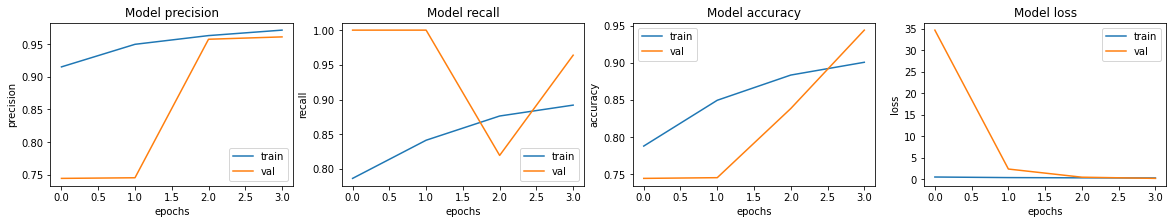

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 57s 1s/step - loss: 0.5947 - accuracy: 0.7596 - precision: 0.7264 - recall: 0.9872
